## Import Libraries

In [7]:
# Standard library imports
import os

# Third-party imports
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.utils.class_weight import compute_class_weight
from sklearn.metrics import classification_report, confusion_matrix
import timm
import torch
import torch.nn as nn
import torch.optim as optim
from torchvision import transforms
from torch.utils.data import Dataset, DataLoader
from PIL import Image
from tqdm import tqdm

## Constants

In [8]:
num_classes = 2 # Malignant and Benign
random_state = 42

# Define paths
metadata_path = os.path.join(os.getcwd(), '../data/metadata_updated.csv')
image_path = os.path.join(os.getcwd(), '../data/images')

# Set device
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

## Load Metadata

In [9]:
metadata = pd.read_csv(metadata_path)

## Split Training and Testing Set

In [10]:
# Split the dataset into training, validation, and test sets
train_df, val_df = train_test_split(
  metadata, 
  test_size=0.4, 
  stratify=metadata['malignant'], 
  random_state=random_state
)

val_df, test_df = train_test_split(
  val_df,
  test_size=0.5,
  stratify=val_df['malignant'],
  random_state=random_state
)

## Prepare Dataset

In [11]:
class SkinDataset(Dataset):
    """
    Custom Dataset for loading skin images and their labels.
    """
    def __init__(self, dataframe, img_dir, transform=None):
        self.dataframe = dataframe.reset_index(drop=True)
        self.img_dir = img_dir
        self.transform = transform

    def __len__(self):
        return len(self.dataframe)

    def __getitem__(self, idx):
        img_path = os.path.join(self.img_dir, self.dataframe.loc[idx, 'DDI_file'])
        label = self.dataframe.loc[idx, 'malignant']
        image = Image.open(img_path).convert("RGB")
        if self.transform:
            image = self.transform(image)
        return image, label

# Transformations

In [23]:
# Define image transformations
train_transform = transforms.Compose([
    transforms.Resize((299, 299)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
    transforms.RandomHorizontalFlip(p=0.1),
    transforms.RandomVerticalFlip(p=0.1),
    transforms.RandomAffine(degrees=20, translate=(0.1, 0.1), scale=(0.9, 1.1)),
    transforms.ColorJitter(brightness=0.2, contrast=0.2, saturation=0.2),
    transforms.RandomErasing(p=0.1, scale=(0.02, 0.1)),
])

test_transform = transforms.Compose([
    transforms.Resize((299, 299)),
    transforms.ToTensor(),
])

## Create Data Loaders

In [13]:
batch_size = 16

# Create datasets
train_dataset = SkinDataset(train_df, image_path, transform=train_transform)
val_dataset = SkinDataset(val_df, image_path, transform=train_transform)
test_dataset = SkinDataset(test_df, image_path, transform=test_transform)

# Create data loaders
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False)
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)

## Initialise Model

In [14]:
model = timm.create_model('xception', pretrained=True)
model.fc = nn.Linear(model.fc.in_features, num_classes)

c:\Users\dango\OneDrive - UWE Bristol\projects\thesis-project\env\lib\site-packages\timm\models\_factory.py:126: UserWarning: Mapping deprecated model name xception to current legacy_xception.
  model = create_fn(


## Train the Model

In [ ]:
epochs = 10
learning_rate = 1e-3
optimizer = optim.Adam(model.parameters(), lr=learning_rate)

# Assuming y is your target array
class_weights = compute_class_weight('balanced', classes=np.unique(train_df['malignant']), y=train_df['malignant'])
class_weights = torch.tensor(class_weights, dtype=torch.float)

# Define the loss function with class weights
criterion = nn.CrossEntropyLoss()

# Move model to device
model = model.to(device)

# For tracking metrics
train_losses = []
train_accuracies = []

for epoch in range(epochs):
    # Set model to training mode
    model.train()
    running_loss = 0.0
    correct = 0
    total = 0
    
    # Create progress bar for this epoch
    train_pbar = tqdm(train_loader, desc=f"Epoch [{epoch+1}/{epochs}]", ncols=120)
    
    # Training loop
    for i, (images, labels) in enumerate(train_pbar):
        # Move data to device
        images, labels = images.to(device), labels.to(device)
        
        # Zero gradients
        optimizer.zero_grad()
        
        # Forward pass
        outputs = model(images)
        
        # Compute loss
        loss = criterion(outputs, labels)
        
        # Back propagation
        loss.backward()
        
        # Update weights
        optimizer.step()
        
        # Update statistics
        running_loss += loss.item()
        mean_loss = running_loss / (i + 1)
        
        # Calculate accuracy
        _, predicted = torch.max(outputs.data, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()
        accuracy = 100 * correct / total

        # Update progress bar with training metrics    
        train_pbar.set_postfix({
            'loss': f'{mean_loss:.4f}', 
            'acc': f'{accuracy:.2f}%',
        })
    
    # Validation step
    with torch.no_grad():
        model.eval()
        val_loss = 0.0
        val_correct = 0
        val_total = 0

        # Create progress bar for validation
        val_pbar = tqdm(val_loader, desc="Validation", ncols=120)

        # Validation loop
        for images, labels in val_pbar:
            images, labels = images.to(device), labels.to(device)
            outputs = model(images)
            loss = criterion(outputs, labels)
            val_loss += loss.item()

            _, predicted = torch.max(outputs.data, 1)
            val_total += labels.size(0)
            val_correct += (predicted == labels).sum().item()

            avg_val_loss = val_loss / len(val_loader)
            val_accuracy = 100 * val_correct / val_total

            # Update progress bar with validation metrics
            val_pbar.set_postfix({
                'val_loss': f'{avg_val_loss:.4f}', 
                'val_acc': f'{val_accuracy:.2f}%'
            })

Validation: 100%|████████████████████████████████████████| 9/9 [00:29<00:00,  3.25s/it, val_loss=0.5945, val_acc=73.28%]


## Save the Model

In [20]:
torch.save(model.state_dict(), os.path.join(os.getcwd(), '../models/xception_skin_cancer.pth'))

## Load the Model

In [ ]:
# model = torch.load(os.path.join(os.getcwd(), '../models/xception_skin_cancer.pth'))

## Test the Model

              precision    recall  f1-score   support

      Benign       0.74      0.99      0.85        97
   Malignant       0.50      0.03      0.05        35

    accuracy                           0.73       132
   macro avg       0.62      0.51      0.45       132
weighted avg       0.68      0.73      0.64       132



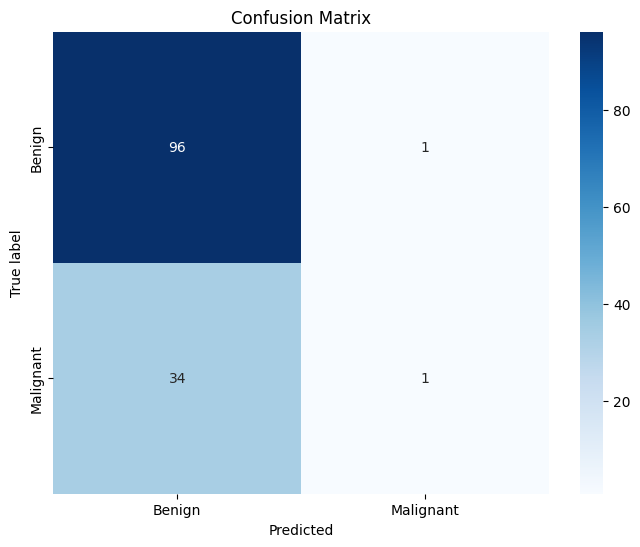

In [21]:
# Initialize lists to store predictions and labels
all_preds = []
all_labels = []

# Evaluate the model on the test set
model.eval()
with torch.no_grad():
    # Loop through the test set
    for images, labels in test_loader:
        # Move data to device
        images, labels = images.to(device), labels.to(device)

        # Forward pass
        outputs = model(images)

        # Get predictions
        preds = torch.argmax(outputs, dim=1)

        # Store predictions and labels
        all_preds.extend(preds.cpu().numpy())
        all_labels.extend(labels.cpu().numpy())

# Classification report
print(classification_report(all_labels, all_preds, target_names=['Benign', 'Malignant']))

# Compute confusion matrix
cm = confusion_matrix(all_labels, all_preds)

# Plot confusion matrix
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', 
            xticklabels=['Benign', 'Malignant'],
            yticklabels=['Benign', 'Malignant'])
plt.xlabel('Predicted')
plt.ylabel('True label')
plt.title('Confusion Matrix')
plt.show()